In [10]:
# import necessary libraries
import pandas as pd 
import numpy
import matplotlib.pyplot as plt 
from pyspark.sql import SparkSession, dataframe
import plotly.express as px
from pyspark.sql import functions as F

geojson = px.data.gapminder()
# create sparksession
spark = SparkSession \
    .builder \
    .appName("CS236Task1") \
    .getOrCreate()

In [11]:
# Utility function to write query plans to a file
# you will be using this to understand how your queries are being processed
def write_explain(df: dataframe.DataFrame, output_path: str = "out.txt"):
    from contextlib import redirect_stdout
    with open(output_path, "w") as f:
        with redirect_stdout(f):
            df.explain(extended=True)

In [12]:
#Spark SQL Approach

#Read the dataset
sdf = spark.read.csv("../data/SupplementalDataCounty.csv", header=True)

#Filter the rows
population2010 = sdf.filter(sdf["Variable_Code"] == "2010_Census_Population")

# Trim spaces from the 'State' column
population2010 = population2010.withColumn("State", F.trim(population2010["State"]))

#Spark SQL query to sum the population of Counties and group by State
stateWiseSum = population2010.groupBy("State").agg(F.sum("Value").cast("integer").alias("Total Population"))

In [13]:
#Display results
stateWiseSum.show()

+-----+----------------+
|State|Total Population|
+-----+----------------+
|   AZ|         6392017|
|   SC|         4625364|
|   LA|         4533372|
|   MN|         5303925|
|   NJ|         8791894|
|   DC|          601723|
|   OR|         3831074|
|   VA|         7994802|
|   RI|         1052567|
|   KY|         4339367|
|   WY|          563626|
|   NH|         1316470|
|   MI|         9883640|
|   NV|         2700551|
|   WI|         5686986|
|   ID|         1567582|
|   CA|        37253956|
|   CT|         3574097|
|   NE|         1826341|
|   MT|          989415|
+-----+----------------+
only showing top 20 rows



In [14]:
#Calculating time for Spark SQL

def sparkSQL():
    sdf = spark.read.csv("../data/SupplementalDataCounty.csv", header=True)
    
    population2010 = sdf.filter(sdf["Variable_Code"] == "2010_Census_Population")
    population2010 = population2010.withColumn("State", F.trim(population2010["State"]))
    stateWiseSum = population2010.groupBy("State").agg(F.sum("Value").cast("integer").alias("Total Population"))

# Time the function execution 1 times
%timeit -n 1 sparkSQL()

78.9 ms ± 8.84 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [15]:
#RDD based approach in Spark

#Read the dataset
df = spark.read.csv("../data/SupplementalDataCounty.csv", header=True)

# Convert DataFrame to RDD
rdd = df.rdd

# Filter rows and map State and type-casted integer value of population
filtered_rdd = rdd \
    .filter(lambda row: row.Variable_Code == "2010_Census_Population") \
    .map(lambda row: (row.State.strip(), int(row.Value)))

# Reduce by key (State) to sum the values of population
state_wise_sum_rdd = filtered_rdd.reduceByKey(lambda a, b: a + b)

#Convert RDD to pandas dataframe
state_wise_sum = state_wise_sum_rdd.toDF(["State", "Total Population"])

In [16]:
#Display results
state_wise_sum.show()

+-----+----------------+
|State|Total Population|
+-----+----------------+
|   AL|         4779736|
|   AK|          710231|
|   AZ|         6392017|
|   AR|         2915918|
|   CA|        37253956|
|   CO|         5029196|
|   CT|         3574097|
|   DE|          897934|
|   DC|          601723|
|   FL|        18801310|
|   GA|         9687653|
|   HI|         1360301|
|   ID|         1567582|
|   IL|        12830632|
|   IN|         6483802|
|   IA|         3046355|
|   KS|         2853118|
|   KY|         4339367|
|   LA|         4533372|
|   ME|         1328361|
+-----+----------------+
only showing top 20 rows



In [17]:
#Calculating time for Spark RDD
def sparkRDD():
    df = spark.read.csv("../data/SupplementalDataCounty.csv", header=True)
    rdd = df.rdd

    filtered_rdd = rdd \
        .filter(lambda row: row.Variable_Code == "2010_Census_Population") \
        .map(lambda row: (row.State, int(row.Value)))
    
    state_wise_sum_rdd = filtered_rdd.reduceByKey(lambda a, b: a + b)

# Time the function execution 1 times
%timeit -n 1 sparkRDD() 

65.8 ms ± 8.45 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


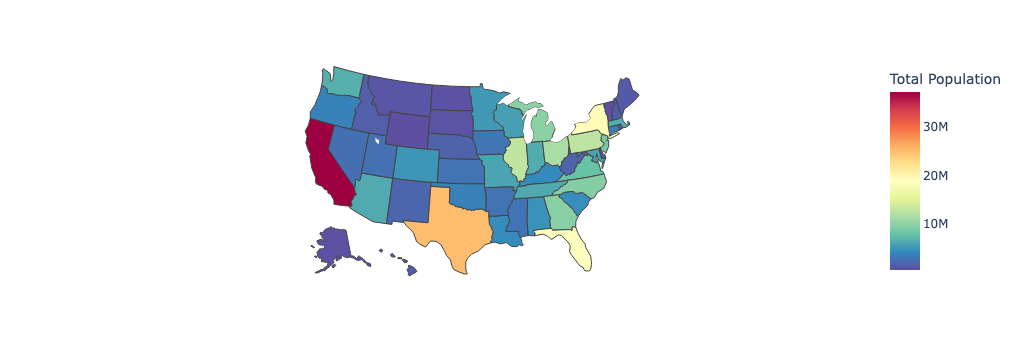

In [18]:
#Plotting the chloropleth map from obtained results

fig = px.choropleth(stateWiseSum,
                    locations='State',
                    color='Total Population',
                    color_continuous_scale='spectral_r',
                    locationmode='USA-states',
                    scope='usa')
fig.update_geos(
    visible=True, 
    scope="usa",
)
fig.show()